In [1]:
import pysm3
import pysm3.units as u
import healpy as hp
import numpy as np
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import sys, platform, os
import matplotlib
from matplotlib import pyplot as plt
import math
import camb
from camb import model, initialpower
print('Using CAMB %s installed at %s'%(camb.__version__,os.path.dirname(camb.__file__)))
# make sure the version and path is what you expect

Using CAMB 1.5.2 installed at /Users/ikumakiyoshi/.julia/conda/3/lib/python3.10/site-packages/camb


In [2]:
nside = 2**4

In [3]:
#Set up a new set of parameters for CAMB
pars = camb.read_ini('/Users/ikumakiyoshi/Library/Mobile Documents/com~apple~CloudDocs/study_fg_rm/program/Deltamap_test/Python_delta_map/params_camb_for_PTEP.ini')
#Set WantTensors to True
pars.WantTensors = True
#This function sets up CosmoMC-like settings, with one massive neutrino and helium set using BBN consistency
pars.set_cosmology(H0=67.5, ombh2=0.022, omch2=0.122, mnu=0.06, omk=0, tau=0.06)
pars.InitPower.set_params(As=2e-9, ns=0.965, r=1)
pars.set_for_lmax(3*nside + 1, lens_potential_accuracy=0)
random_seed = 5123
pars.RandomSeed = random_seed;

In [4]:
#calculate results for these parameters
results = camb.get_results(pars)

#get dictionary of CAMB power spectra
powers =results.get_cmb_power_spectra(pars, lmax = 3*nside + 1, CMB_unit='muK', raw_cl=True)
for name in powers: print(name)

total
unlensed_scalar
unlensed_total
lensed_scalar
tensor
lens_potential


In [5]:
cl_scal = powers['unlensed_scalar']
cl_tens = powers['tensor']
cl_lens = powers['lensed_scalar']
cl_pot = powers['lens_potential']
cl_total = powers['total']

r = 0.01

cl = cl_scal + r * cl_tens + cl_lens

#without lense
#cl = cl_scal + r * cl_tens

In [6]:
import healpy as hp
seed = 12345
np.random.seed(seed)
cmb_map = hp.synfast(cl.T, nside, new = True)

In [7]:
import warnings
warnings.filterwarnings("ignore")

In [8]:
Synch = pysm3.Sky(nside, preset_strings=["s1"])

In [9]:
Synch.components

In [10]:
map_Synch_40GHz = Synch.get_emission(40 * u.GHz)
map_Synch_140GHz = Synch.get_emission(140 * u.GHz)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [11]:
map_Synch_40GHz = map_Synch_40GHz.to(u.uK_CMB, equivalencies=u.cmb_equivalencies(40*u.GHz))
map_Synch_140GHz = map_Synch_140GHz.to(u.uK_CMB, equivalencies=u.cmb_equivalencies(140*u.GHz))

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

In [13]:
#hp.mollview(map_CMB_140GHz[0], title=" map", unit = map_CMB_140GHz.unit)
#hp.mollview(map_Synch_40GHz[2], title=" map", unit = map_Synch_40GHz.unit)
#hp.mollview(map_Synch_140GHz[0], title=" map", unit = map_Synch_140GHz.unit)

## Clean MAP

In [14]:
N_pix = hp.nside2npix(nside)

## $\vec{m} = ({[Q,U]_{\nu_1}(\hat{n}_i)},...,{[Q,U]_{\nu_{Nfreq}}(\hat{n}_{i})})$

In [15]:
# Data m

data_m = pysm3.Sky(nside, preset_strings=["s1"])

## $\vec{m}$ for each channel

In [16]:
m_40GHz = data_m.get_emission(40 * u.GHz)
m_140GHz = data_m.get_emission(140 * u.GHz)
m_50GHz = data_m.get_emission(50 * u.GHz)
m_100GHz = data_m.get_emission(100 * u.GHz)

# μK_R to μK_CMB

m_40GHz = m_40GHz.to(u.uK_CMB, equivalencies=u.cmb_equivalencies(40*u.GHz)).value + cmb_map
m_140GHz = m_140GHz.to(u.uK_CMB, equivalencies=u.cmb_equivalencies(140*u.GHz)).value + cmb_map
m_50GHz = m_50GHz.to(u.uK_CMB, equivalencies=u.cmb_equivalencies(50*u.GHz)).value + cmb_map
m_100GHz = m_100GHz.to(u.uK_CMB, equivalencies=u.cmb_equivalencies(100*u.GHz)).value + cmb_map

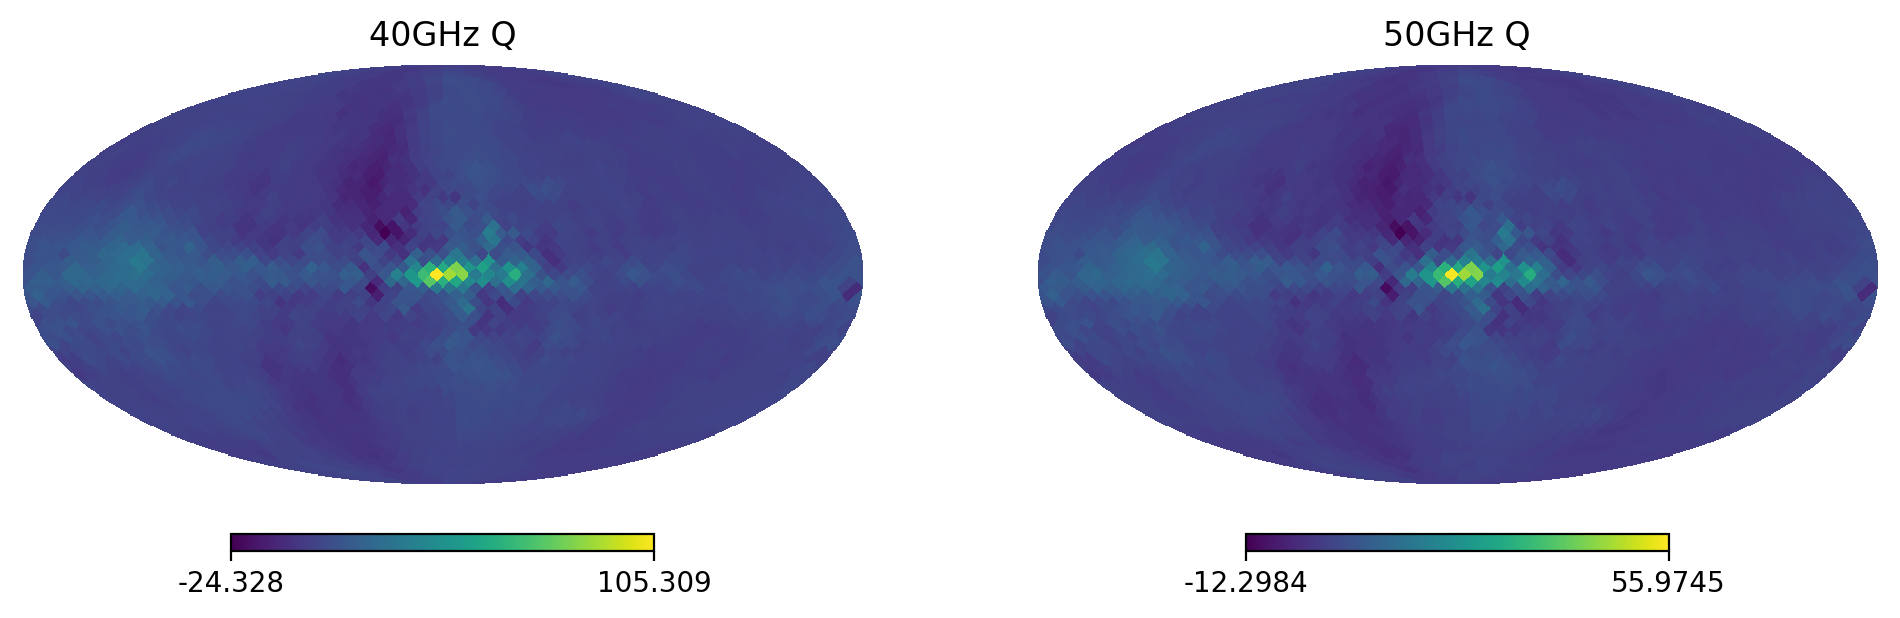

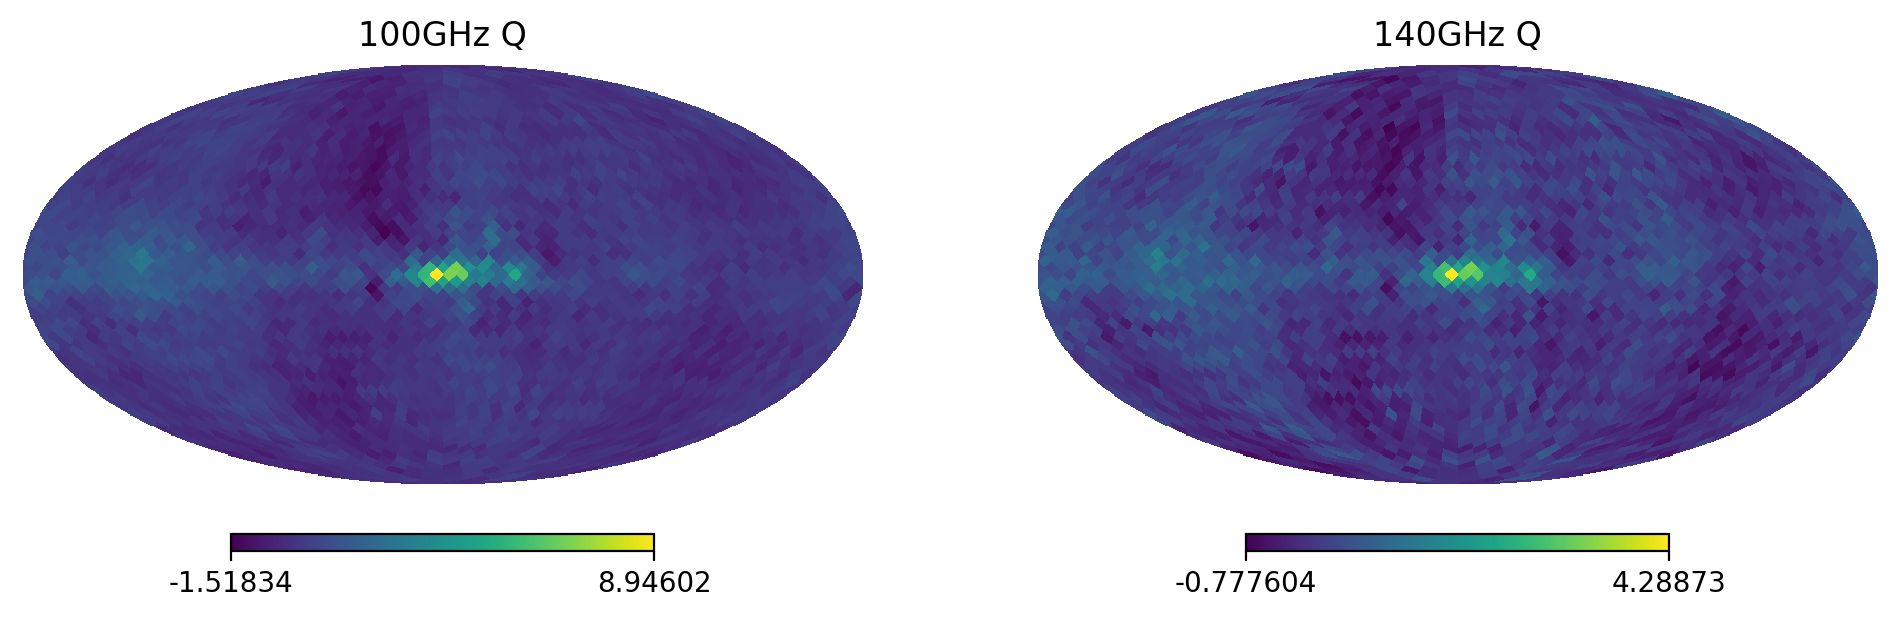

In [17]:
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))

plt.axes(ax1)
hp.mollview(m_40GHz[1], title="40GHz Q", hold=True)

plt.axes(ax2)
hp.mollview(m_50GHz[1], title="50GHz Q", hold=True)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))

plt.axes(ax1)
hp.mollview(m_100GHz[1], title="100GHz Q",hold=True)

plt.axes(ax2)
hp.mollview(m_140GHz[1], title="140GHz Q",hold=True)

## Q, U of m for each channel

In [18]:
m_40GHz_Q = m_40GHz[1]
m_50GHz_Q = m_50GHz[1]
m_100GHz_Q = m_100GHz[1]
m_140GHz_Q = m_140GHz[1]


m_40GHz_U = m_40GHz[2]
m_50GHz_U = m_50GHz[2]
m_100GHz_U = m_100GHz[2]
m_140GHz_U = m_140GHz[2]

##### $\vec{m} = [[Q,U]_{40GHz}(\hat{n}_{i}),[Q,U]_{100GHz}(\hat{n}_{i}),[Q,U]_{140GHz}(\hat{n}_{i})]^T$

In [19]:
data_m = np.concatenate((m_40GHz_Q, m_40GHz_U, m_100GHz_Q ,m_100GHz_U, m_140GHz_Q ,m_140GHz_U), axis=0).T

print(len(data_m))
data_m 

18432


array([-1.22679742, -0.14618418, -0.55580986, ...,  0.38426489,
       -0.34588213, -0.29669219])

#### $\boldsymbol{D}=[\boldsymbol{D}^{CMB},\boldsymbol{D}^{synch}(\bar{\beta}),\boldsymbol{D}^{synch}_{,1}]$

<img src="D_1.png" width="450"><img src="D.png" width="450">

## D elements

### $\nu_{b*} = 23$ GHz, $\beta_s = -3.0$

In [20]:
def D_element(freq, freq_b = 23 * 10**9, beta = -3.):

    # x = (f / T) * (h / k)
    x = (freq / 2.725) / (2.083661912 * 10**10)
    
    g_freq = ((np.exp(x) - 1)**2) / (np.exp(x) * x**2) * 1000.0

    
    d = g_freq * (freq/freq_b)**(beta)

    dd = g_freq * (freq/freq_b)**(beta) * np.log(freq/freq_b)
    
    return d, dd

# freq_b = 23 GHz, beta = -3.0
d_40, dd_40 = D_element(40 * 10**9)
d_50, dd_50 = D_element(50 * 10**9)
d_100, dd_100 = D_element(100 * 10**9)
d_140, dd_140 = D_element(140 * 10**9)

"""
d_40, dd_40 = D_element(40 * 10**9, 23 * 10**9, -3.0)
d_50, dd_50 = D_element(50 * 10**9, 23 * 10**9, -3.0)
d_100, dd_100 = D_element(100 * 10**9, 23 * 10**9, -3.0)
d_140, dd_140 = D_element(140 * 10**9, 23 * 10**9, -3.0)
"""

# D Matrix

diag = np.identity(2 * N_pix)

# Block Matrix, CMB + FG
D = np.block([[diag, d_40 * diag, dd_40 * diag], [diag, d_100 * diag, dd_100 * diag], [diag, d_140 * diag, dd_140 * diag]])

print(D.shape)

D.dtype

(18432, 18432)


dtype('float64')

In [21]:
print(d_100)
print(dd_100)

15.655770107481453
23.008909119732586


In [22]:
print(d_40)
print(dd_40)

198.10299376952253
109.62727239226652


In [23]:
#　make noise covariance matrix

N_freq = int(len(data_m) / N_pix)

diag = np.identity(N_pix)

noise = np.random.normal(loc=0., scale=1., size = N_pix)

noise_40 = diag * np.random.normal(loc=0., scale=1., size = N_pix)

noise_140 = diag * np.random.normal(loc=0., scale=1., size = N_pix)

#noise_nest = hp.pixelfunc.reorder(noise, inp='RING', out='NEST')

#hp.mollview(noise, title='noise')

In [24]:
x = np.zeros(N_pix)

## Calculate Clean Map

<img src="clean_map.png" width="450">


#### $N + 2 = N_{freq}$ $\Longrightarrow$ $CMB^{ML}(\hat{n})=[\boldsymbol{D}^{-1}\vec{m}]$

In [25]:
import sys
sys.path.append('/Users/ikumakiyoshi/Library/Mobile Documents/com~apple~CloudDocs/study_fg_rm/program/Deltamap_test/Python_delta_map/function')

import fg_make_file as fg
import cmb_make_file as cmb
import Delta_map as dm
import numpy as np
import healpy as hp
import warnings
warnings.filterwarnings("ignore")

Using CAMB 1.5.2 installed at /Users/ikumakiyoshi/.julia/conda/3/lib/python3.10/site-packages/camb


In [26]:
import time

start = time.time() 

CMB_map = dm.calc_clean_map(data_m, D, nside)

end = time.time()

time_diff = end - start
print(time_diff)

25.407229900360107


### Power spectrum

In [59]:
CMB_map_Q = clean_map[N_pix*0:N_pix*1]
CMB_map_U = clean_map[N_pix*1:N_pix*2]

In [60]:
I = np.zeros(N_pix)

Clean_map = [I, CMB_map_Q, CMB_map_U]

Input_map = [I, cmb_map[1], cmb_map[2]]

"""
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))
plt.axes(ax1)
hp.mollview(Clean_map[2], title="140GHz Q",hold=True)
plt.axes(ax2)
hp.mollview(CMB_map_U, title="140GHz Q",hold=True)
"""

'\nfig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))\nplt.axes(ax1)\nhp.mollview(Clean_map[2], title="140GHz Q",hold=True)\nplt.axes(ax2)\nhp.mollview(CMB_map_U, title="140GHz Q",hold=True)\n'

In [61]:
import math

l = np.arange(0, 3*nside, 1)

Clean_map_cl = hp.sphtfunc.anafast(Clean_map)

Input_map_cl = hp.sphtfunc.anafast(Input_map)

Clean_map_dl = Clean_map_cl * l * (l + 1) / (2 * math.pi)

Input_map_dl = Input_map_cl * l * (l + 1) / (2 * math.pi)

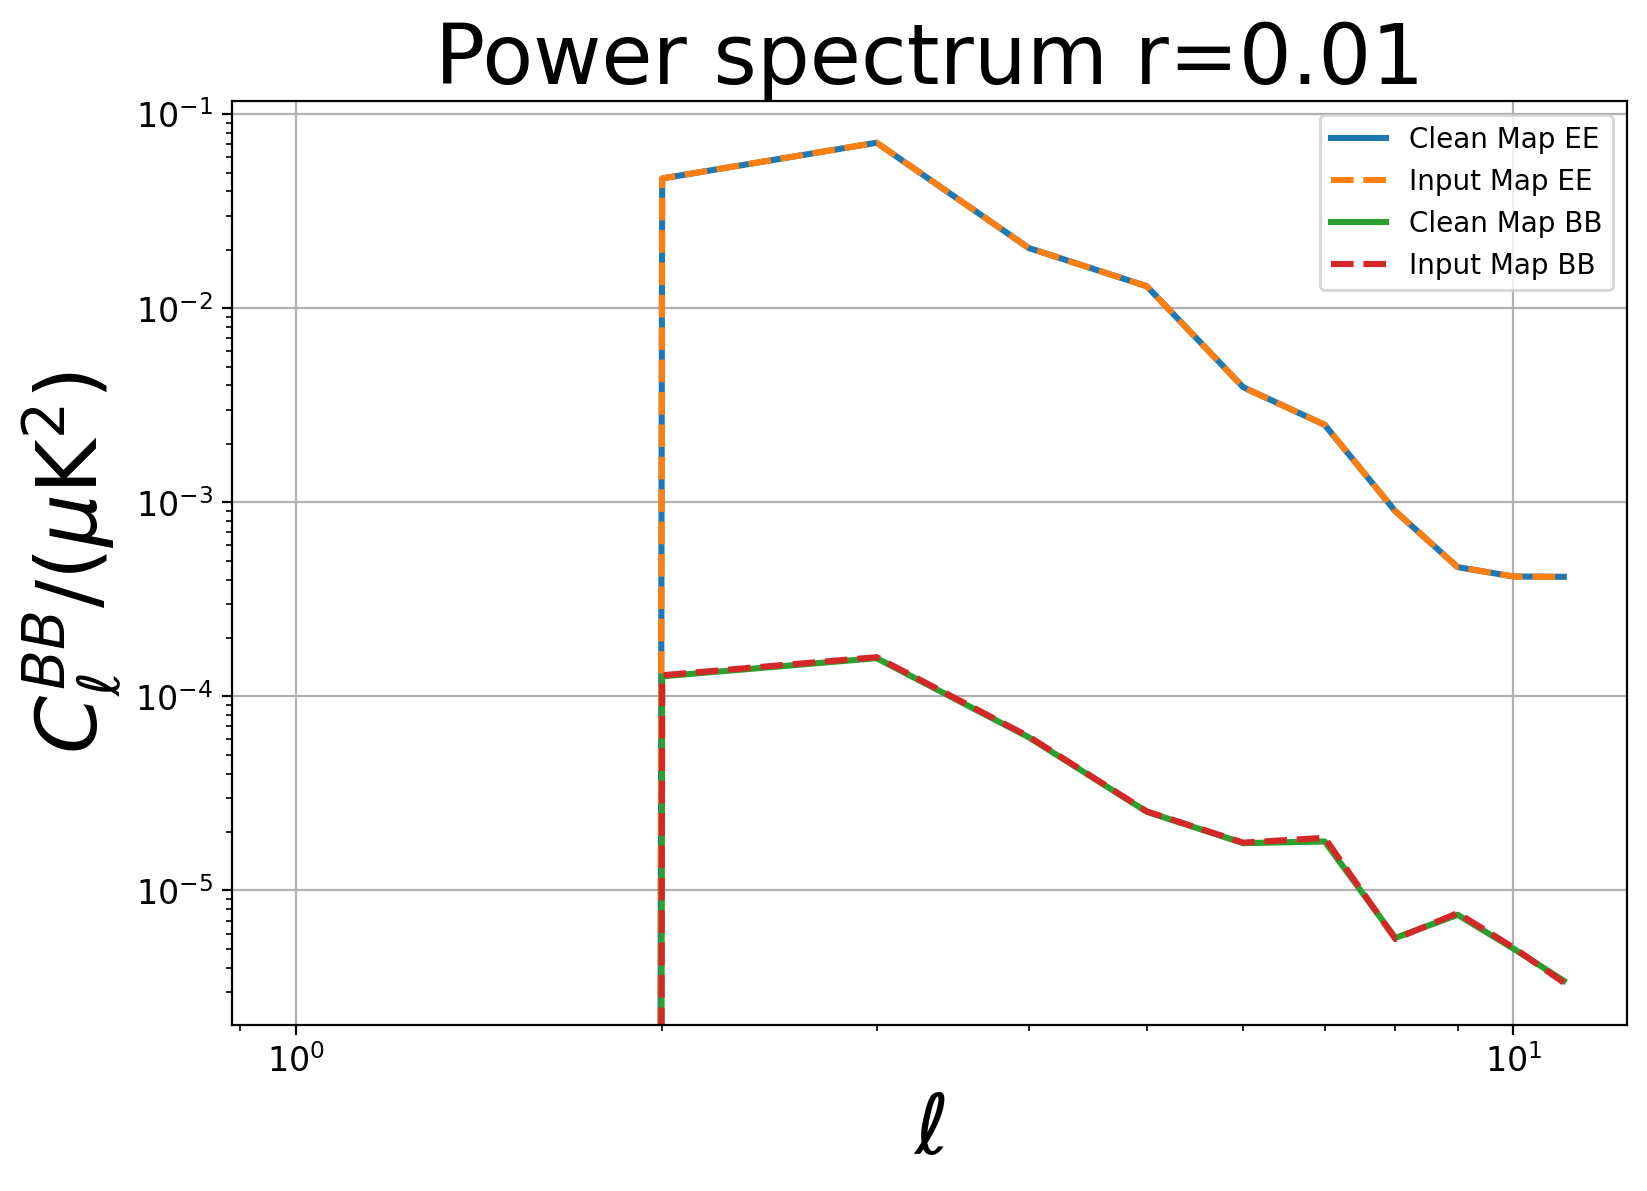

In [62]:
import matplotlib.pyplot as plt

#plot#
fig = plt.figure(figsize=(9, 6))

plt.loglog(l, Clean_map_cl[1] , lw = 2.2, label="Clean Map EE")
plt.loglog(l, Input_map_cl[1], lw=2.2, linestyle='dashed', label="Input Map EE")

"""
np.save("cl_file/Clean_cl_s1_EE_new.npy", Clean_map_cl[1])
np.save("cl_file/Input_cl_s1_EE_new.npy", Clean_map_cl[1])
"""

plt.loglog(l, Clean_map_cl[2] , lw = 2.2, label="Clean Map BB")
plt.loglog(l, Input_map_cl[2], lw = 2.2, linestyle='dashed', label="Input Map BB")

"""
np.save("cl_file/Clean_cl_s1_BB_new.npy", Clean_map_cl[2])
np.save("cl_file/Input_cl_s1_BB_new.npy", Clean_map_cl[2])
"""

plt.ylabel(r'$C_\ell^{BB}/ (\mu{\rm K}^2)$', fontsize=30)
plt.xlabel(r'$\ell$', fontsize=30)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.title("Power spectrum r=" + str(r), fontsize=30)

plt.grid()
plt.legend()

#plt.savefig('Power_spectrum.png', bbox_inches='tight')
plt.show()

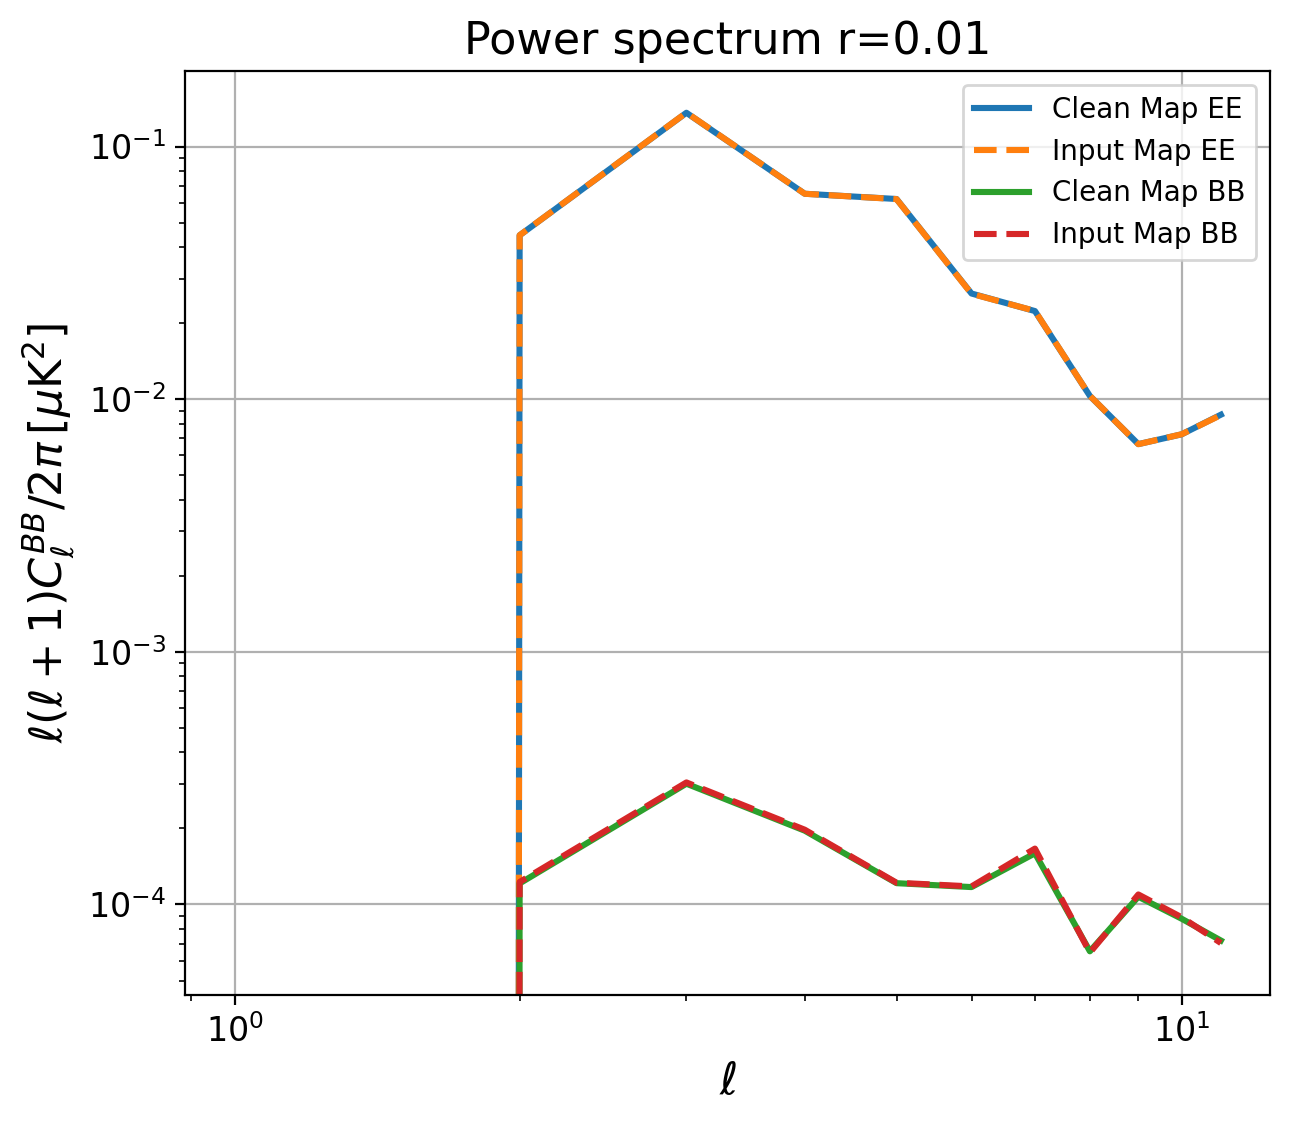

In [63]:
import matplotlib.pyplot as plt

#plot#
fig = plt.figure(figsize=(7, 6))

plt.loglog(l, Clean_map_dl[1] , lw = 2.2, label="Clean Map EE")
plt.loglog(l, Input_map_dl[1], lw=2.2, linestyle='dashed', label="Input Map EE")
"""
np.save("dl_file/Clean_dl_s1_EE_new.npy", Clean_map_dl[1])
np.save("dl_file/Input_dl_s1_EE_new.npy", Clean_map_dl[1])
"""

plt.loglog(l, Clean_map_dl[2] , lw = 2.2, label="Clean Map BB")
plt.loglog(l, Input_map_dl[2], lw = 2.2, linestyle='dashed', label="Input Map BB")

"""
np.save("dl_file/Clean_dl_s1_BB_new.npy", Clean_map_dl[2])
np.save("dl_file/Input_dl_s1_BB_new.npy", Clean_map_dl[2])
"""

plt.ylabel(r'$\ell(\ell+1)C_\ell^{BB}/2\pi\,[\mu {\rm K}^2]$', fontsize=16)
plt.xlabel(r'$\ell$', fontsize=16)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

#plt.ylim(10**-12, 10**-0)

plt.title("Power spectrum r=" + str(r), fontsize=16)

plt.grid()
plt.legend()

#plt.savefig('Power_spectrum.png', bbox_inches='tight')
plt.show()

In [64]:
"""
import matplotlib.pyplot as plt

#plot#
fig = plt.figure(figsize=(7, 6))

plt.loglog(l, Clean_map_dl[1] , lw = 2.2, label="Clean Map EE")
plt.loglog(l, Input_map_dl[1], lw=2.2, linestyle='dashed', label="Input Map EE")


plt.loglog(l, Clean_map_dl[2] , lw = 2.2, label="Clean Map BB")
plt.loglog(l, Input_map_dl[2], lw = 2.2, linestyle='dashed', label="Input Map BB")


plt.ylabel(r'$C_\ell^{BB}/ (\mu{\rm K}^2)$', fontsize=16)
plt.xlabel(r'$\ell$', fontsize=16)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

#plt.ylim(10**-12, 10**-0)

plt.title("Power spectrum", fontsize=16)

plt.grid()
plt.legend()

#plt.savefig('Power_spectrum.png', bbox_inches='tight')
plt.show()
"""

'\nimport matplotlib.pyplot as plt\n\n#plot#\nfig = plt.figure(figsize=(7, 6))\n\nplt.loglog(l, Clean_map_dl[1] , lw = 2.2, label="Clean Map EE")\nplt.loglog(l, Input_map_dl[1], lw=2.2, linestyle=\'dashed\', label="Input Map EE")\n\n\nplt.loglog(l, Clean_map_dl[2] , lw = 2.2, label="Clean Map BB")\nplt.loglog(l, Input_map_dl[2], lw = 2.2, linestyle=\'dashed\', label="Input Map BB")\n\n\nplt.ylabel(r\'$C_\\ell^{BB}/ (\\mu{\rm K}^2)$\', fontsize=16)\nplt.xlabel(r\'$\\ell$\', fontsize=16)\n\nplt.xticks(fontsize=12)\nplt.yticks(fontsize=12)\n\n#plt.ylim(10**-12, 10**-0)\n\nplt.title("Power spectrum", fontsize=16)\n\nplt.grid()\nplt.legend()\n\n#plt.savefig(\'Power_spectrum.png\', bbox_inches=\'tight\')\nplt.show()\n'

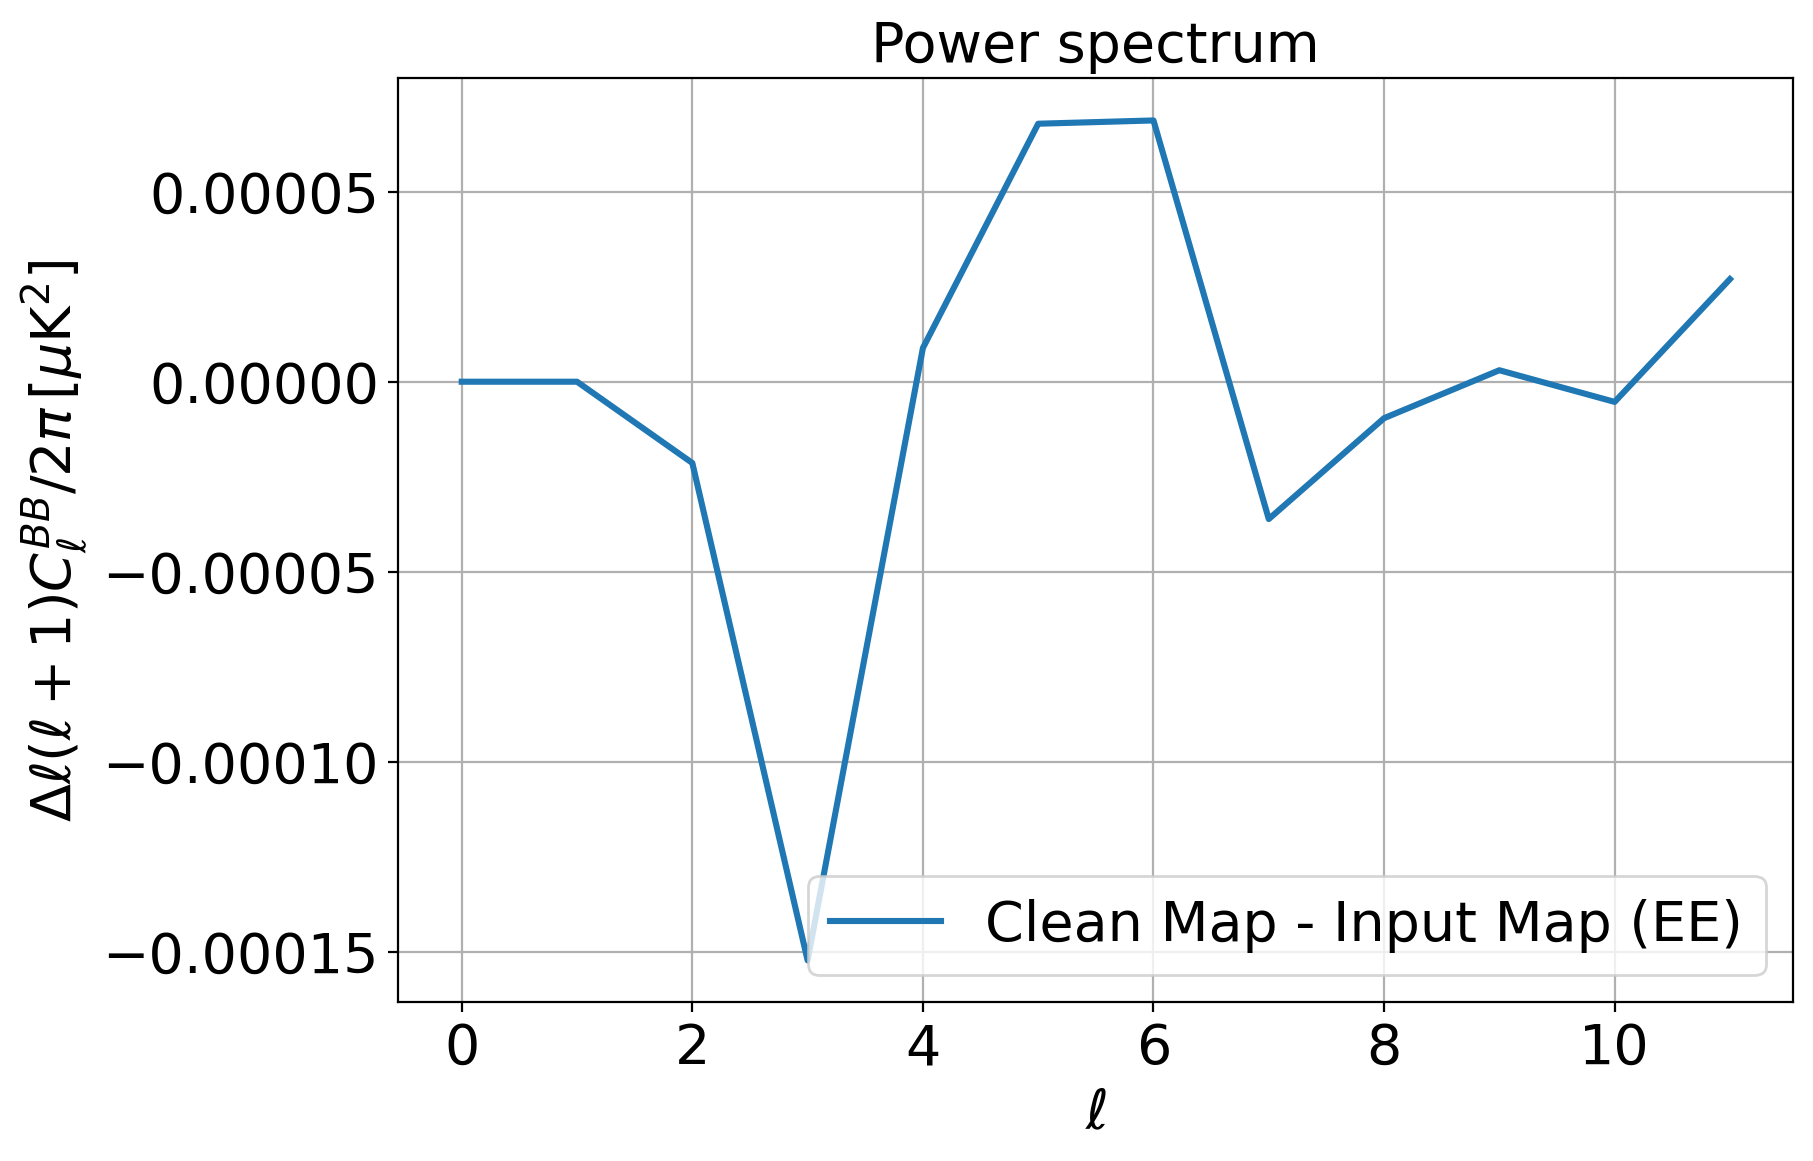

In [65]:
import matplotlib.pyplot as plt
import matplotlib as mpl

#plot#
fig = plt.figure(figsize=(9, 6))

plt.plot(l, Clean_map_dl[1] - Input_map_dl[1] , lw = 2.2, label="Clean Map - Input Map (EE)")

plt.ylabel(r'Δ$\ell(\ell+1)C_\ell^{BB}/2\pi\,[\mu {\rm K}^2]$', fontsize=20)
plt.xlabel(r'$\ell$', fontsize=20)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

mpl.rcParams['font.size'] = 20
plt.title("Power spectrum", fontsize=20)

plt.grid()
plt.legend(fontsize=20)

#plt.savefig('diff.png', bbox_inches='tight')
plt.show()

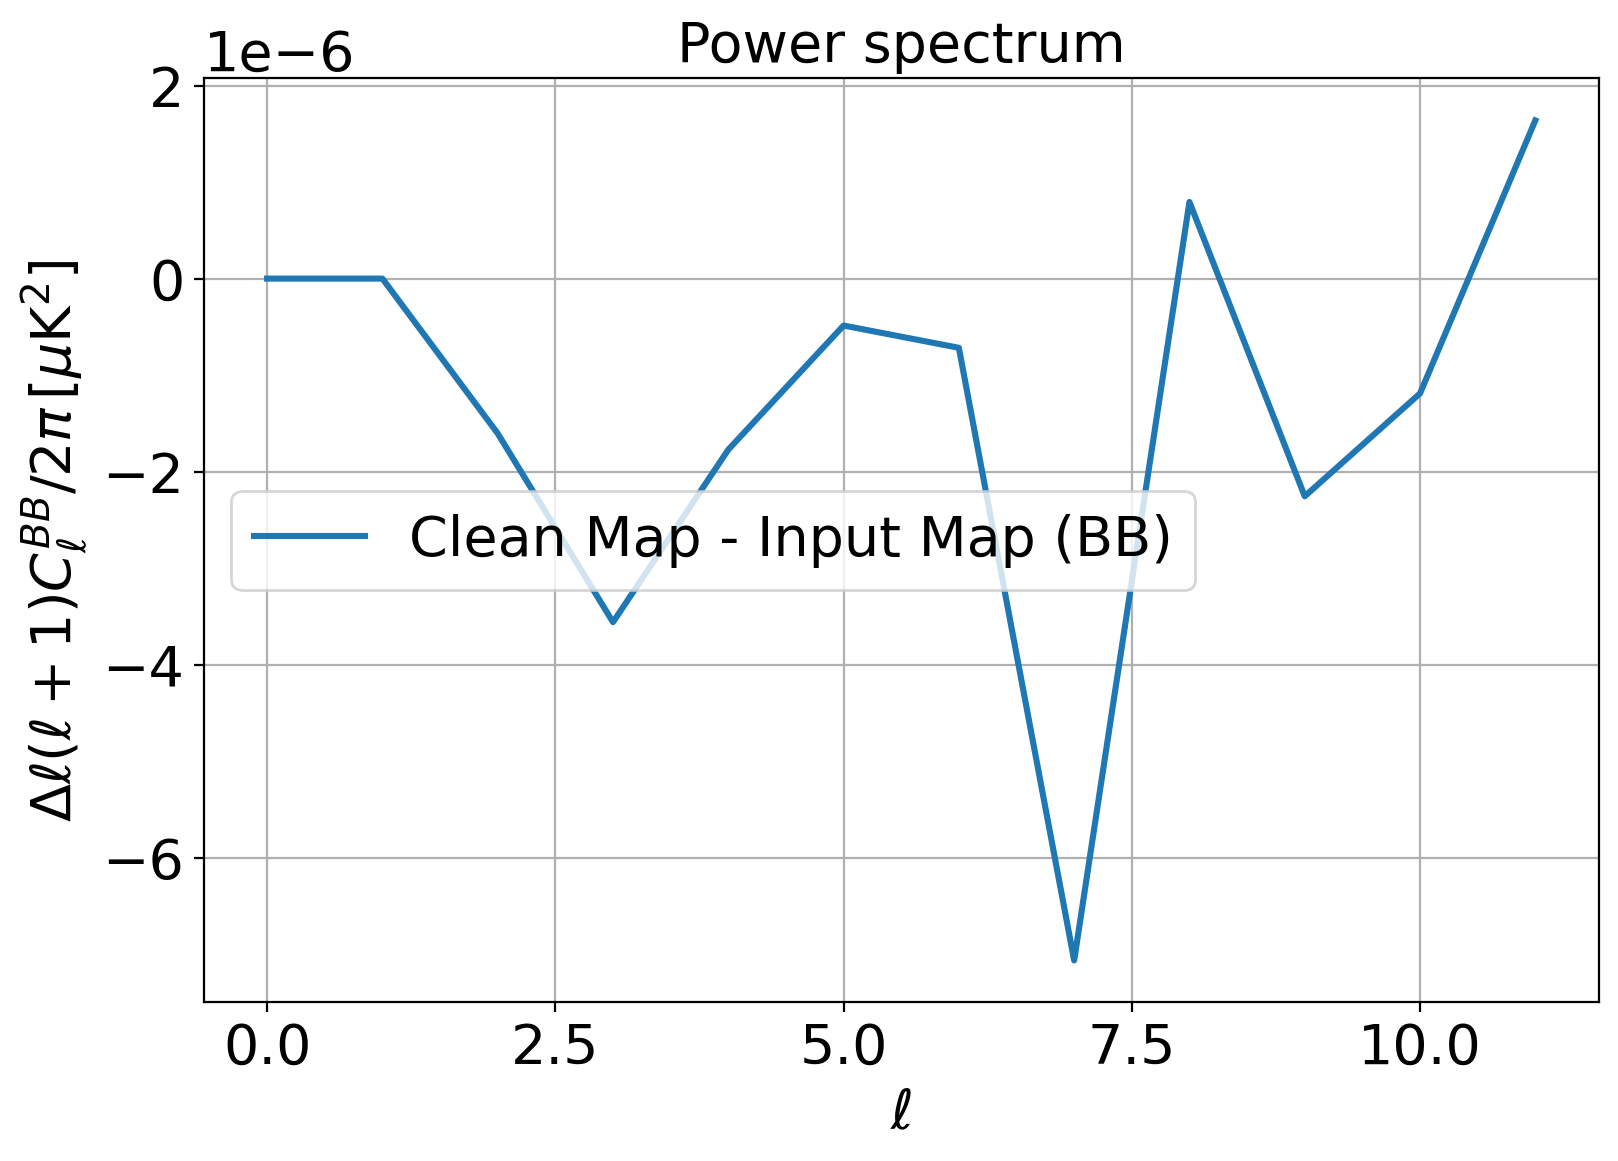

In [66]:
import matplotlib.pyplot as plt
import matplotlib as mpl

#plot#
fig = plt.figure(figsize=(9, 6))

plt.plot(l, Clean_map_dl[2] - Input_map_dl[2] , lw = 2.2, label="Clean Map - Input Map (BB)")

plt.ylabel(r'Δ$\ell(\ell+1)C_\ell^{BB}/2\pi\,[\mu {\rm K}^2]$', fontsize=20)
plt.xlabel(r'$\ell$', fontsize=20)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

mpl.rcParams['font.size'] = 30

plt.title("Power spectrum", fontsize=20)

plt.grid()
plt.legend(fontsize=20)

#plt.savefig('diff.png', bbox_inches='tight')
plt.show()

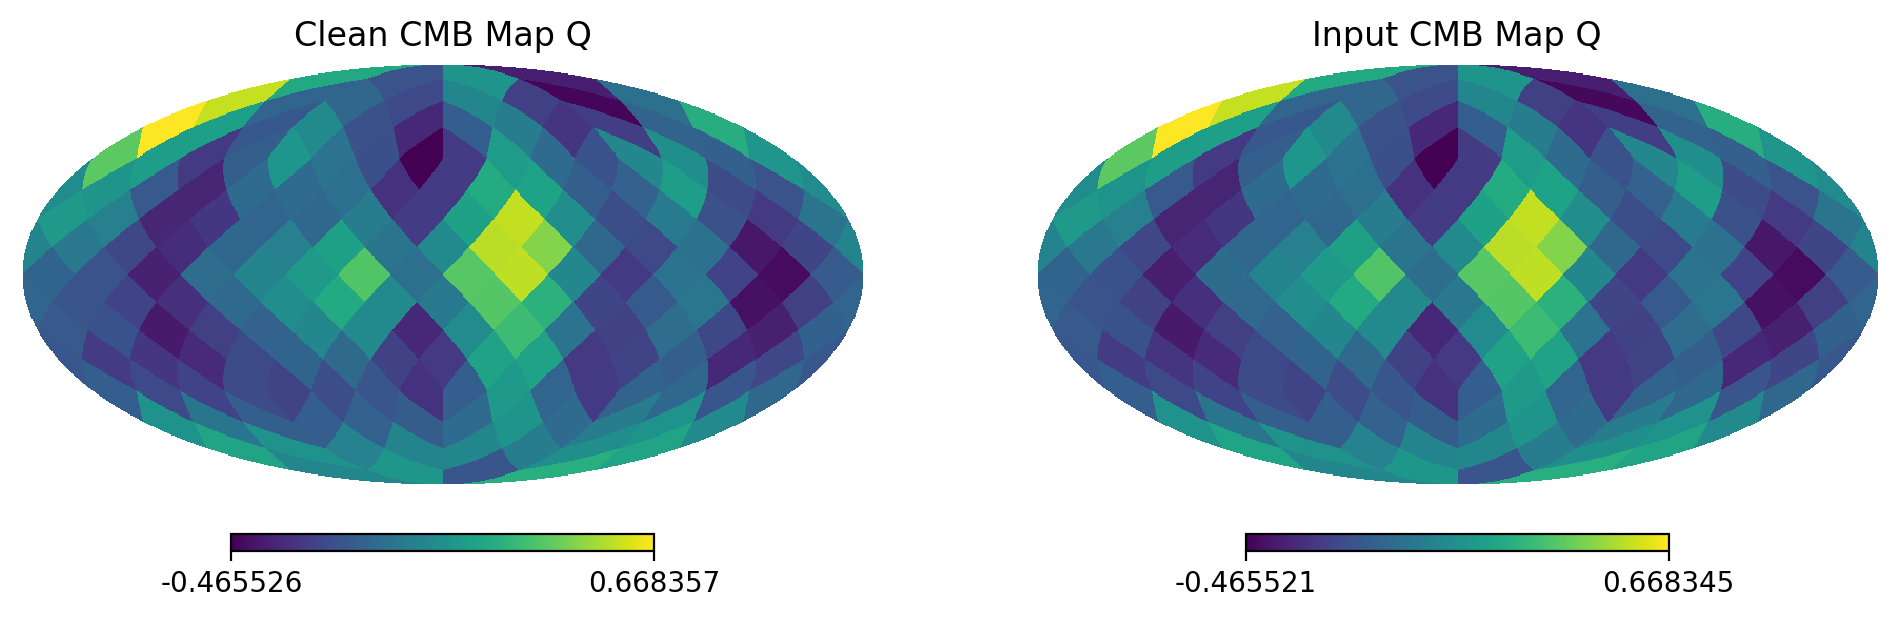

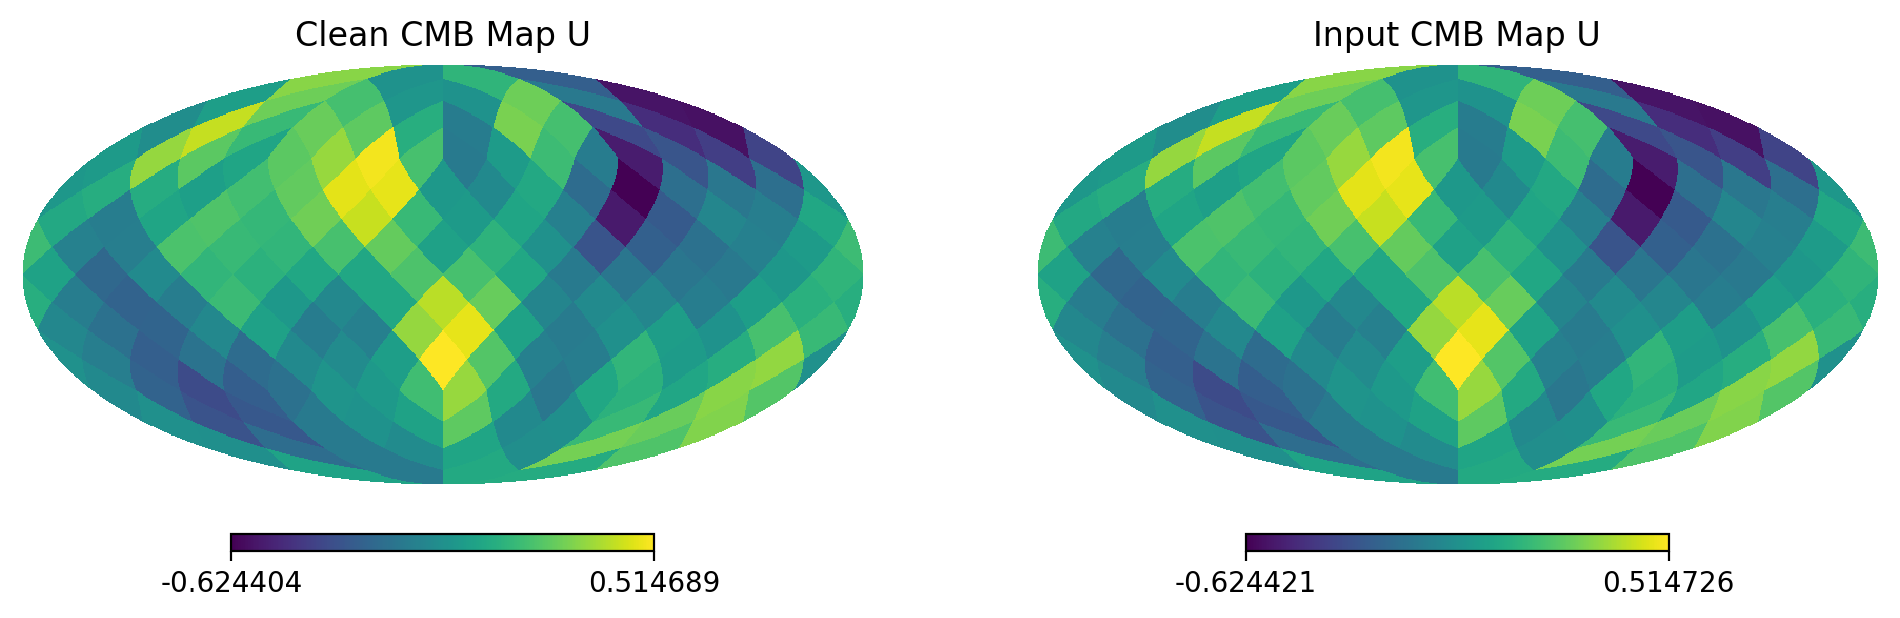

In [70]:
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))

plt.axes(ax1)
hp.mollview(CMB_map_Q, title="Clean CMB Map Q", hold=True)

plt.axes(ax2)
hp.mollview(cmb_map[1], title="Input CMB Map Q", hold=True)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))

plt.axes(ax1)
hp.mollview(CMB_map_U, title="Clean CMB Map U",hold=True)

plt.axes(ax2)
hp.mollview(cmb_map[2], title="Input CMB Map U",hold=True)

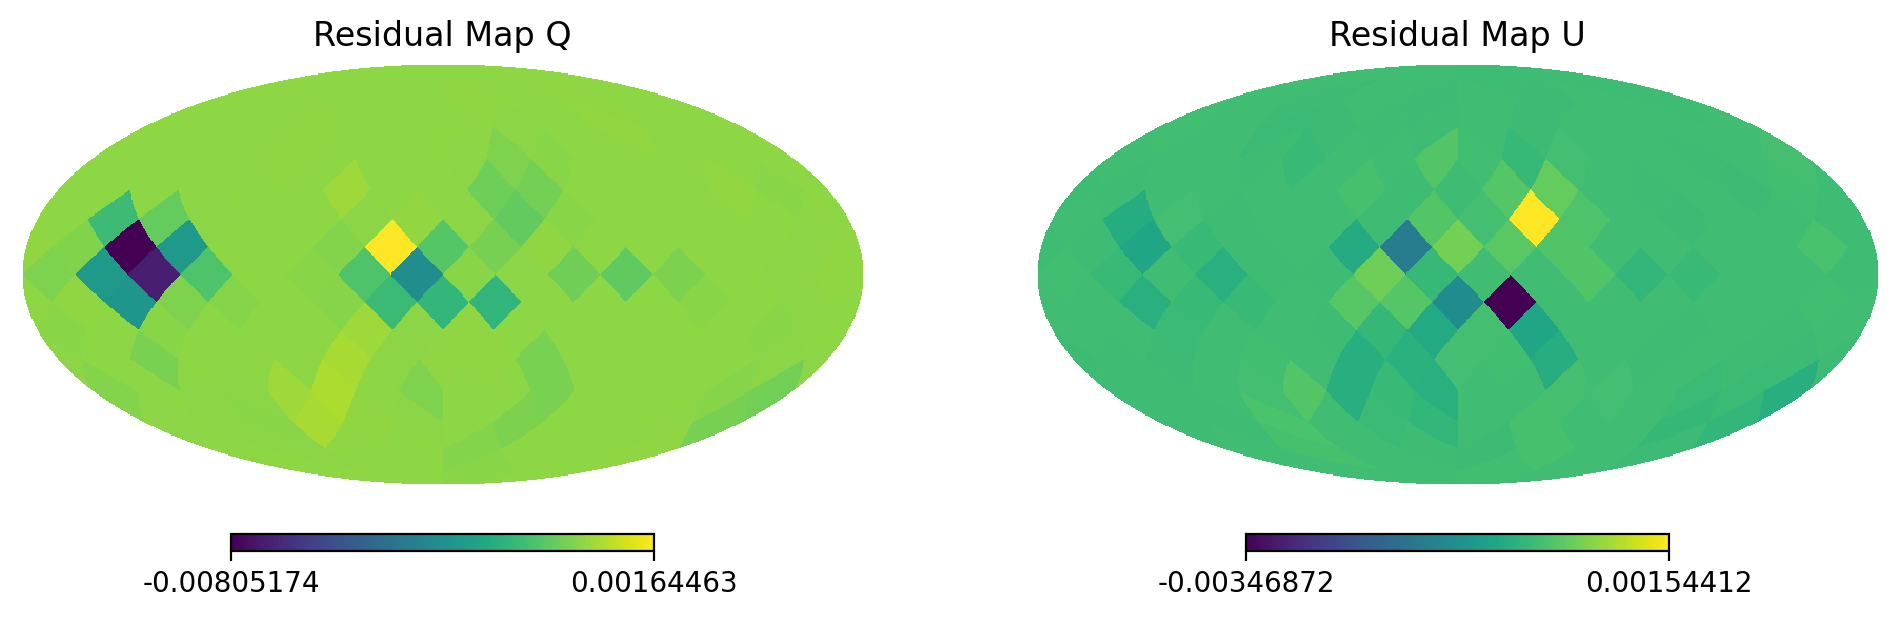

In [69]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))

mpl.rcParams['font.size'] = 10

plt.axes(ax1)
hp.mollview(cmb_map[1] - CMB_map_Q, title="Residual Map Q", hold=True)

plt.axes(ax2)
hp.mollview(cmb_map[2] - CMB_map_U, title="Residual Map U", hold=True)

In [85]:
I_no = cmb_map[0]*0

In [86]:
Residual_map_cl = hp.sphtfunc.anafast([I_no, cmb_map[1] - CMB_map_Q, cmb_map[2] - CMB_map_U])

[ 0.00000000e+00  0.00000000e+00 -4.24250960e-08 -4.87924243e-08
  2.46943402e-08  1.74484748e-08  1.44305867e-08 -2.26034287e-07
  4.76061168e-08 -7.13625945e-08 -3.74773438e-08  4.95034052e-08]


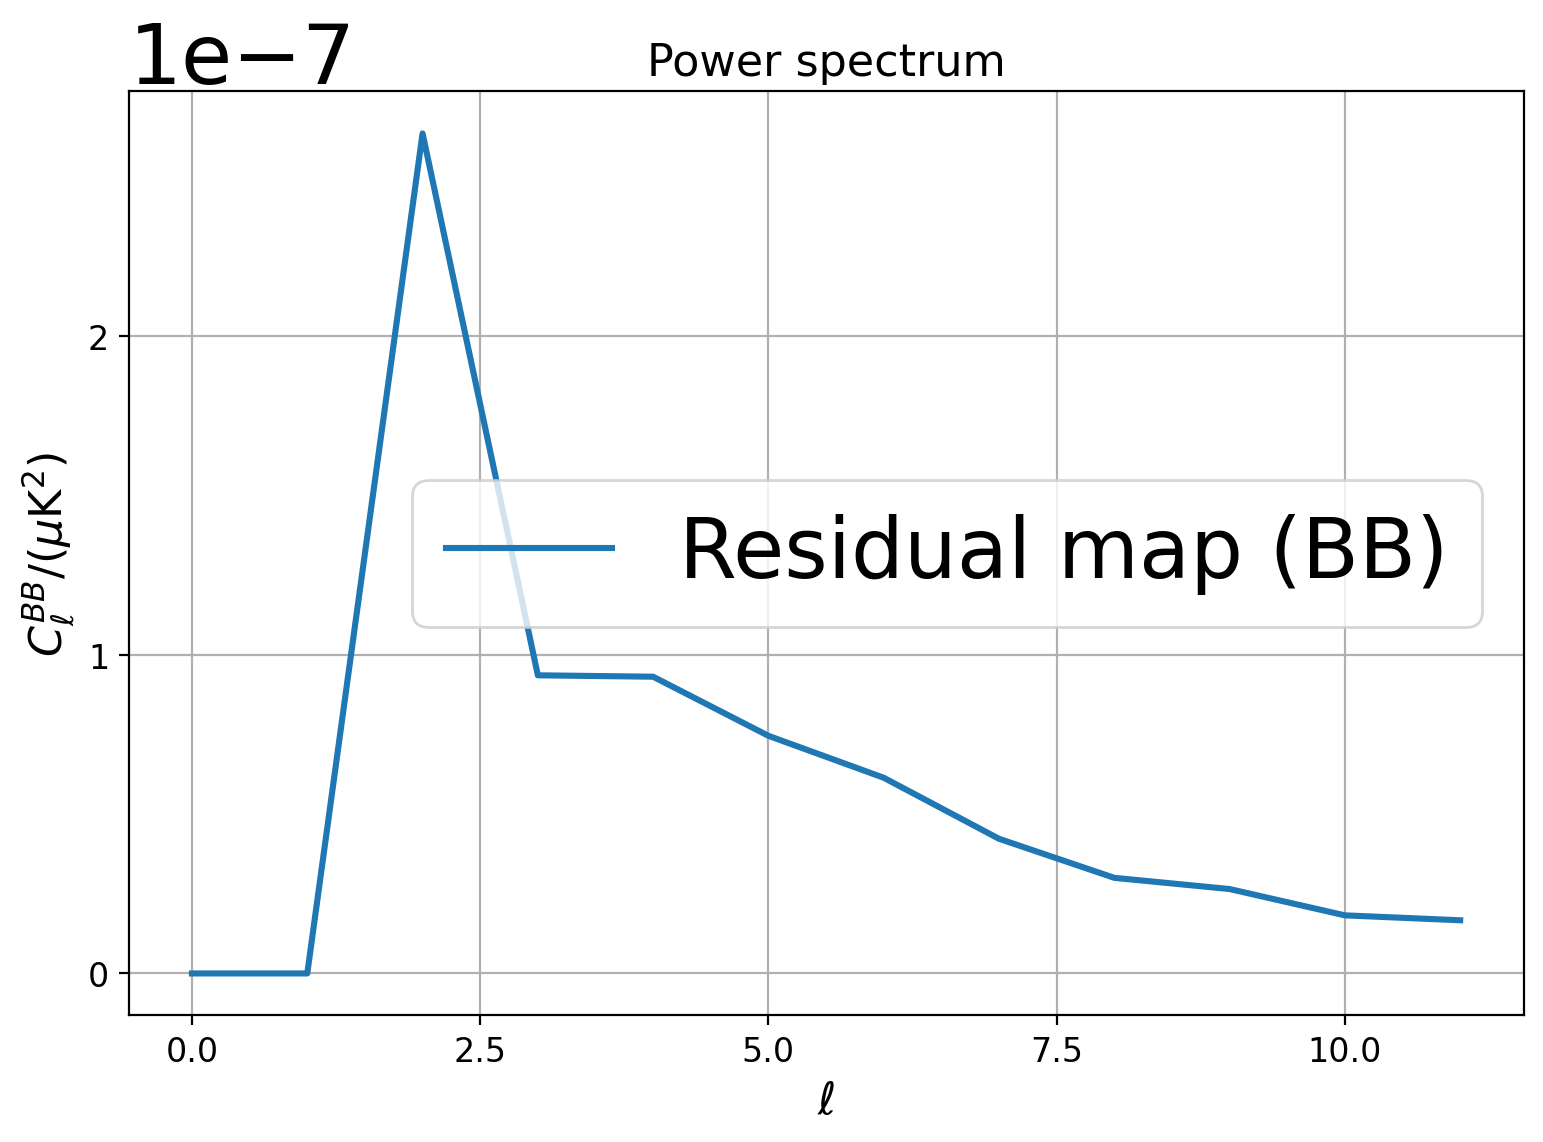

In [87]:
import matplotlib.pyplot as plt

#plot#
fig = plt.figure(figsize=(9, 6))

plt.plot(l, Residual_map_cl[1] , lw = 2.2, label="Residual map (BB)")

print(Clean_map_cl[2] - Input_map_cl[2])

plt.ylabel(r'$C_\ell^{BB}/ (\mu{\rm K}^2)$', fontsize=16)
plt.xlabel(r'$\ell$', fontsize=16)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)


plt.title("Power spectrum", fontsize=16)

plt.grid()
plt.legend()

#plt.savefig('diff.png', bbox_inches='tight')
plt.show()

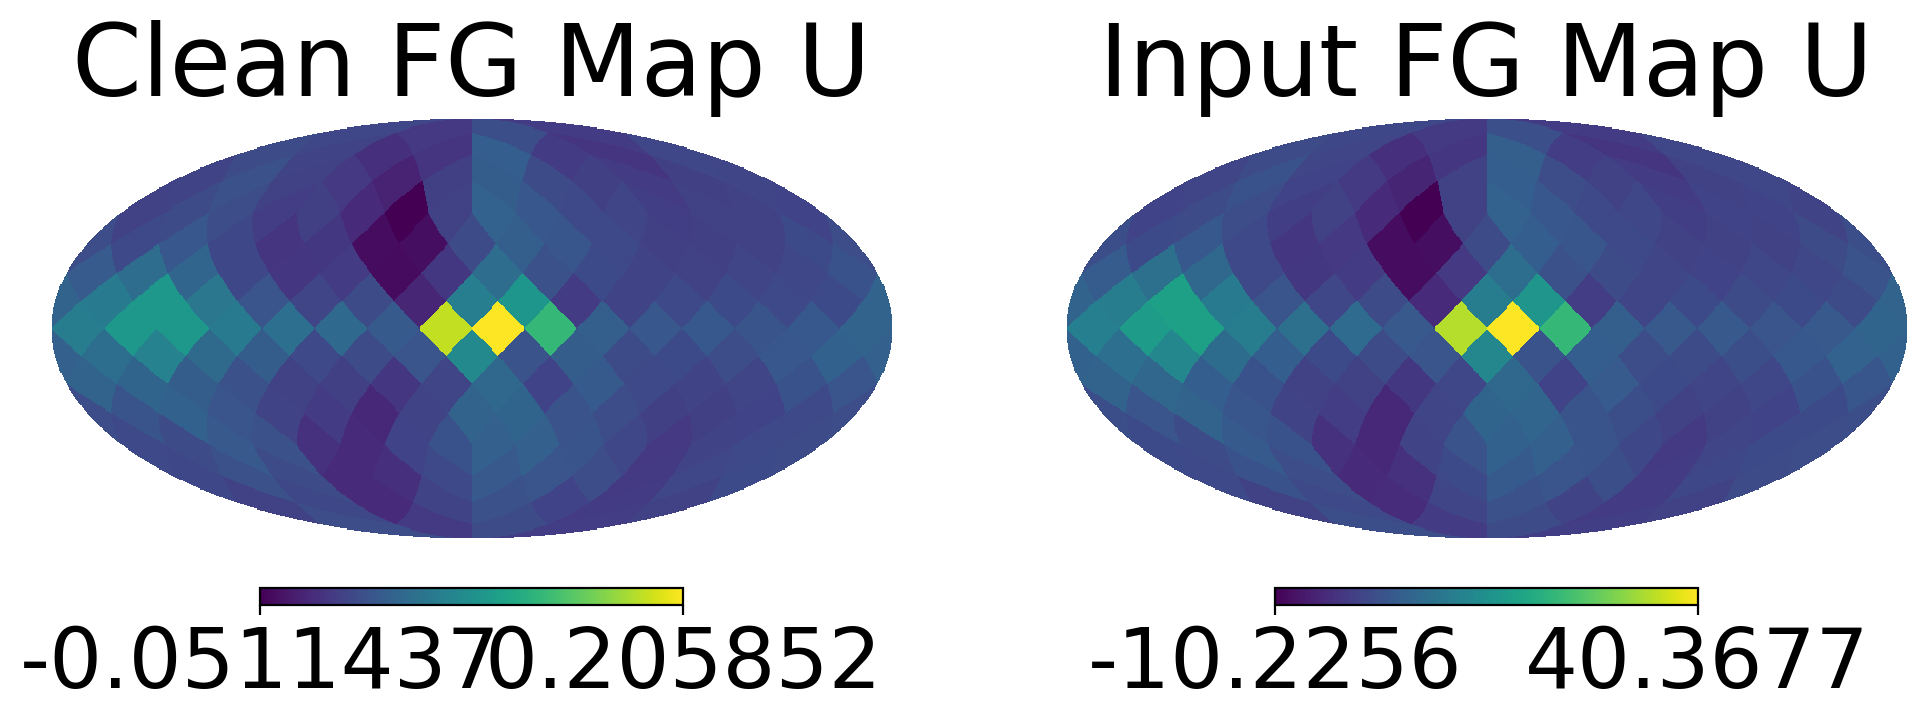

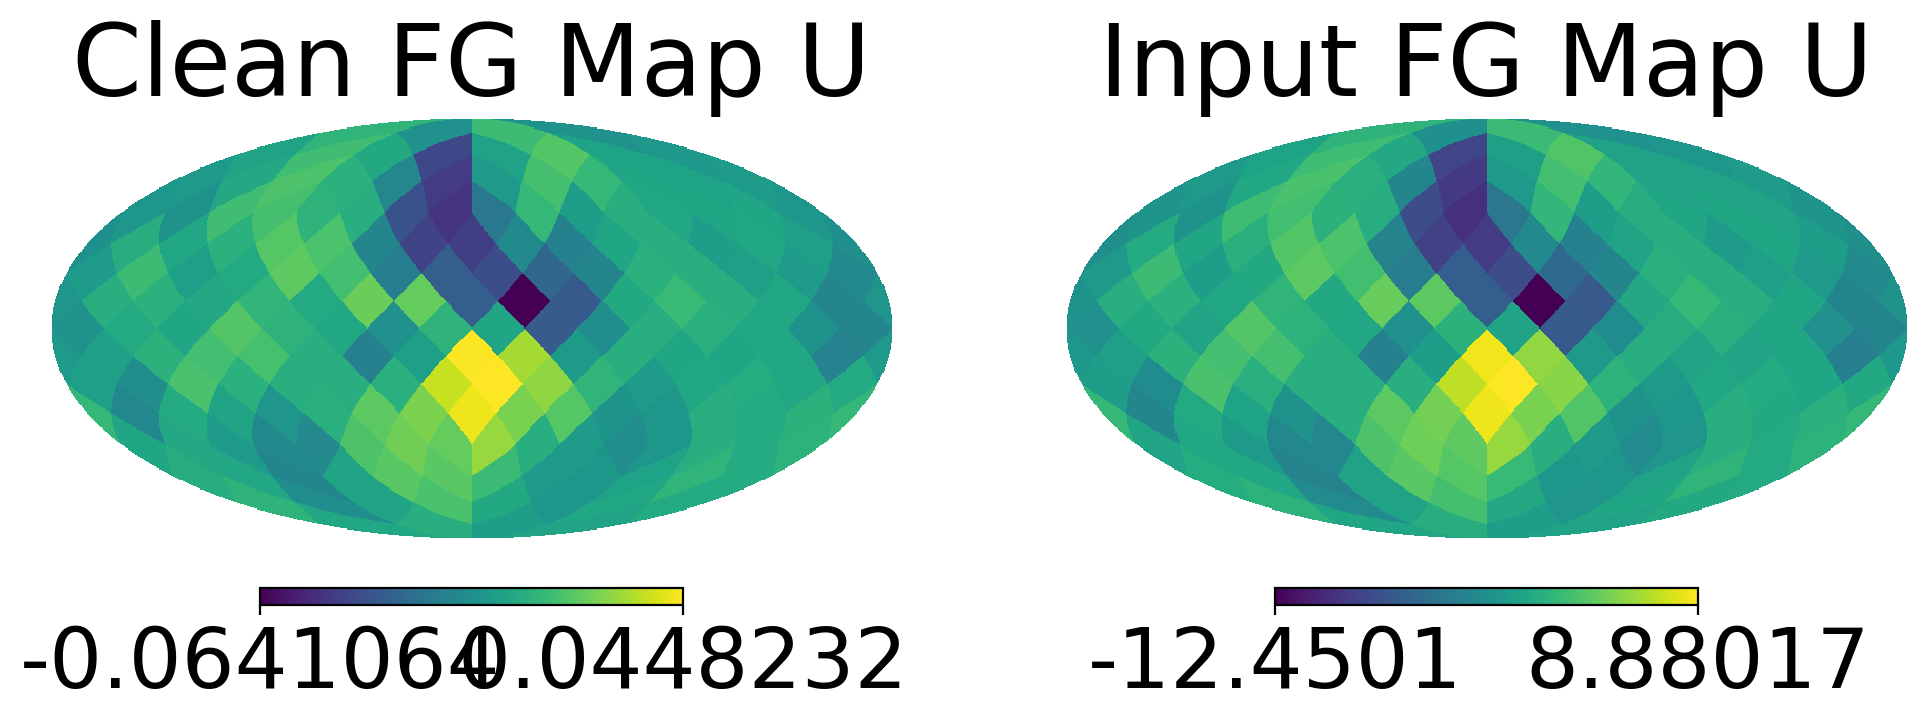

In [88]:
# FG Map

FG_map_Q = clean_map[N_pix*2:N_pix*3]
FG_map_U = clean_map[N_pix*3:N_pix*4]

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))

plt.axes(ax1)
hp.mollview(FG_map_Q, title="Clean FG Map U",hold=True)

plt.axes(ax2)
hp.mollview(map_Synch_40GHz[1], title="Input FG Map U",hold=True)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))

plt.axes(ax1)
hp.mollview(FG_map_U, title="Clean FG Map U",hold=True)

plt.axes(ax2)
hp.mollview(map_Synch_40GHz[2], title="Input FG Map U",hold=True)

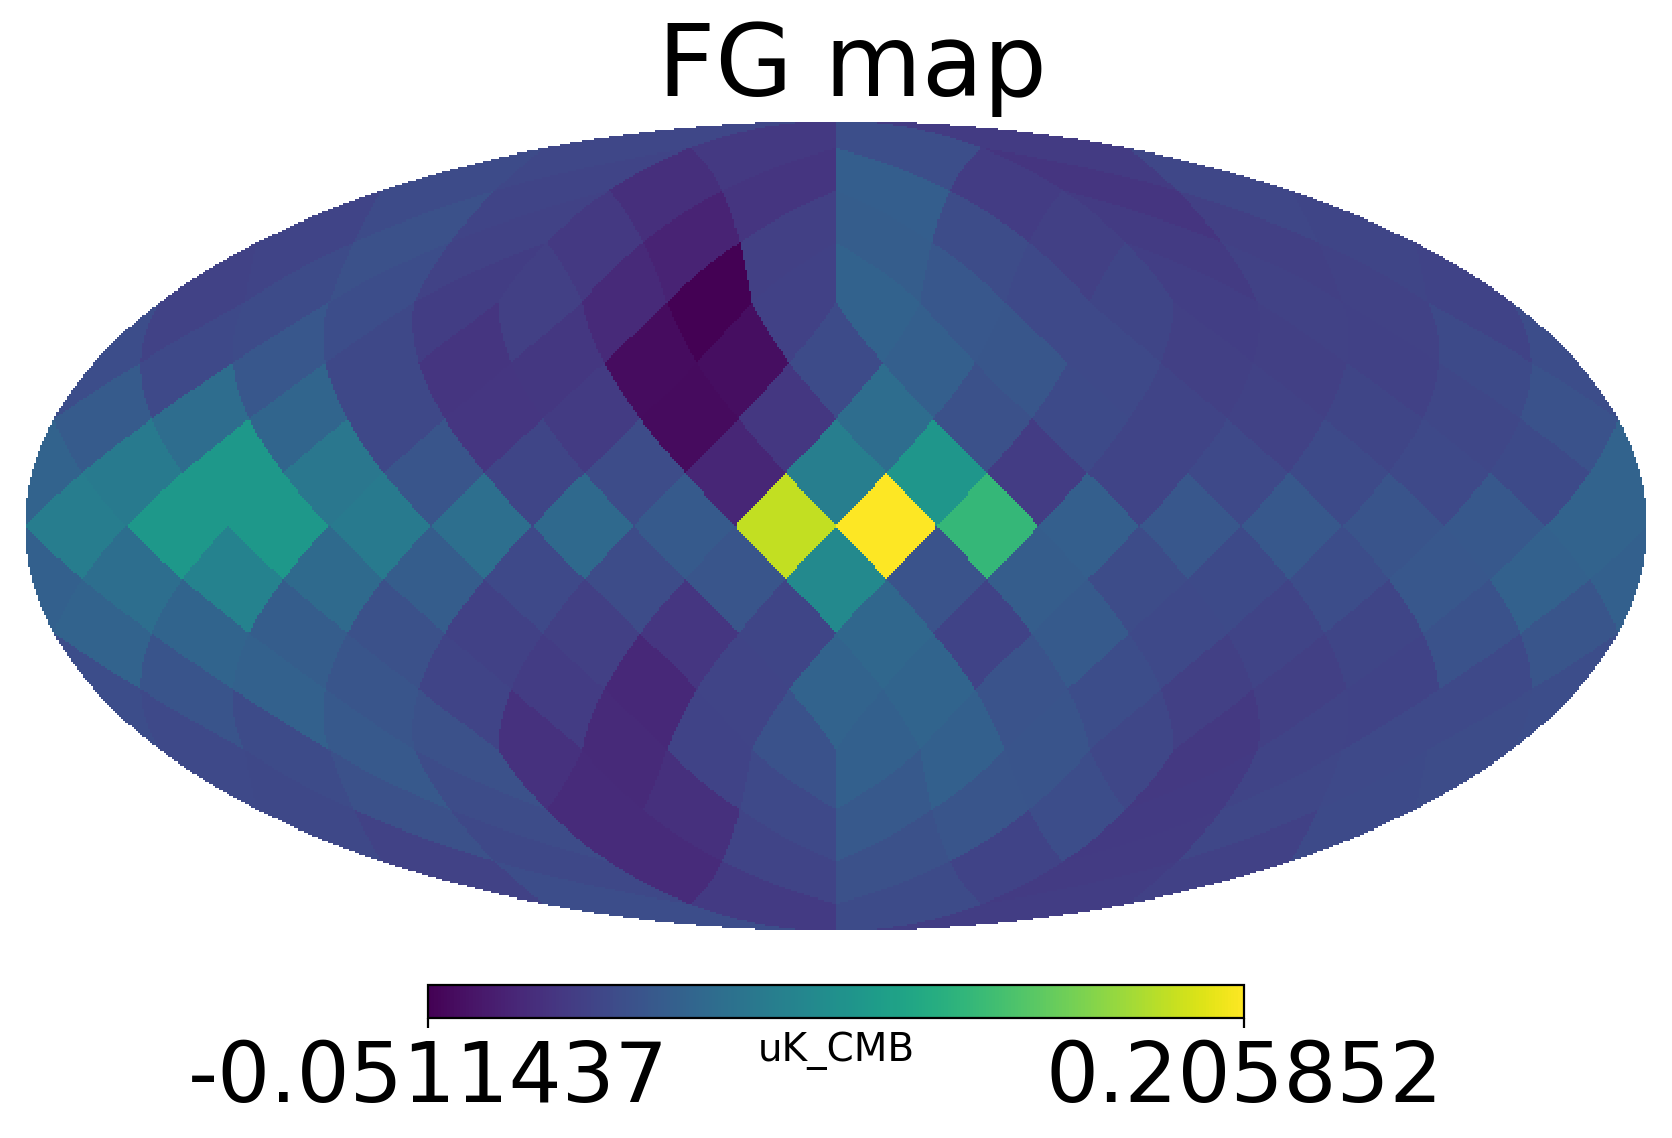

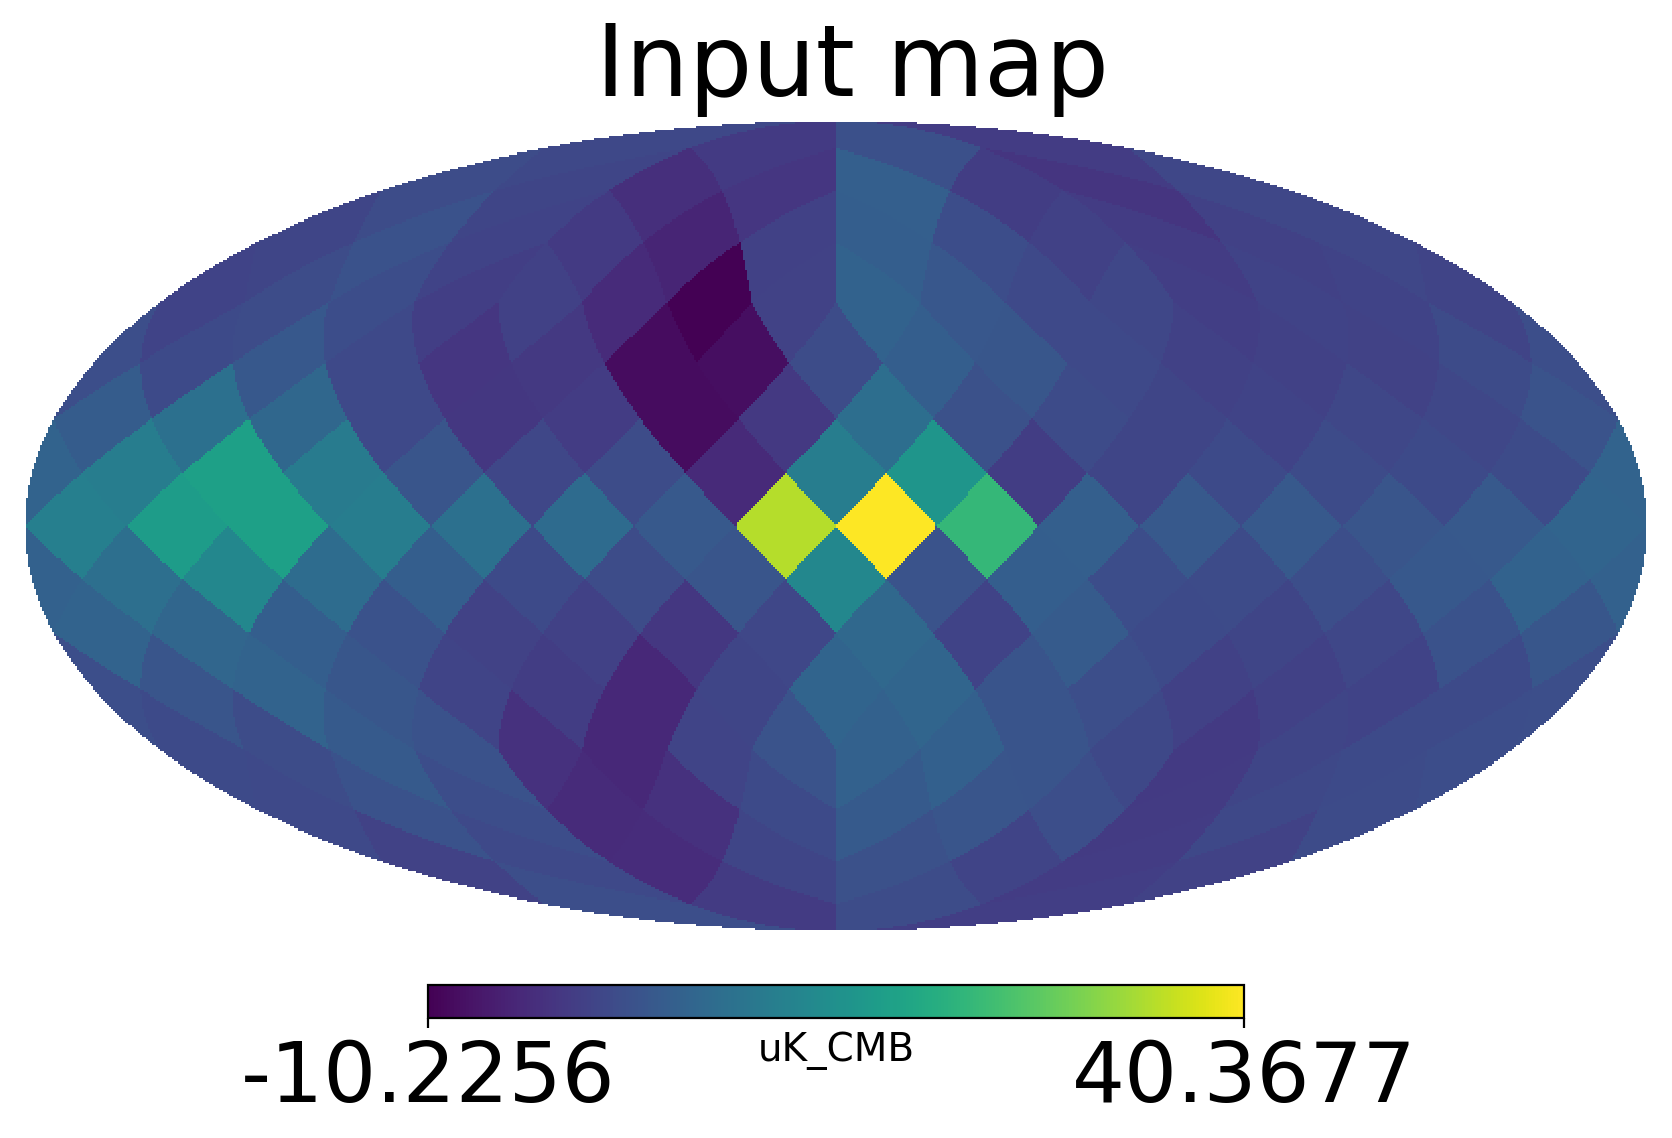

In [89]:
FG_map_Q = clean_map[N_pix*2:N_pix*3]
FG_map_U = clean_map[N_pix*3:N_pix*4]

hp.mollview(FG_map_Q, title=" FG map", unit = map_Synch_40GHz.unit)
hp.mollview(map_Synch_40GHz[1], title=" Input map", unit = map_Synch_40GHz.unit)

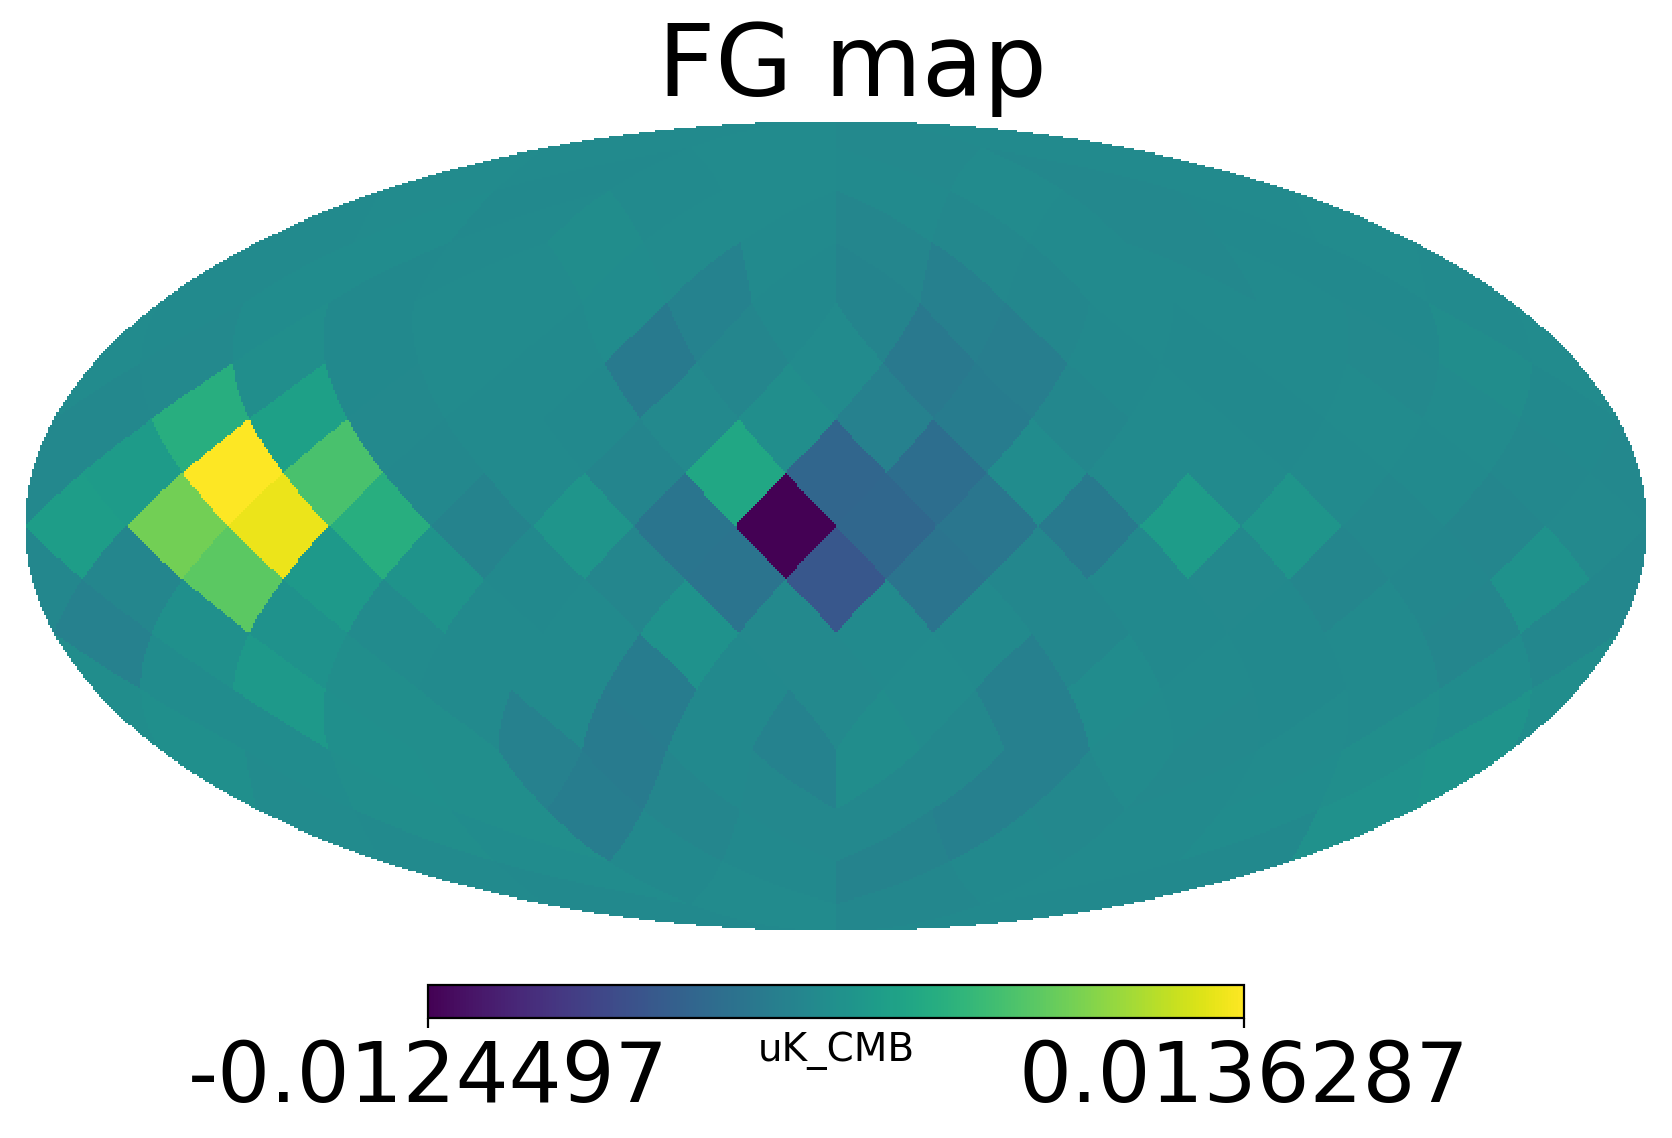

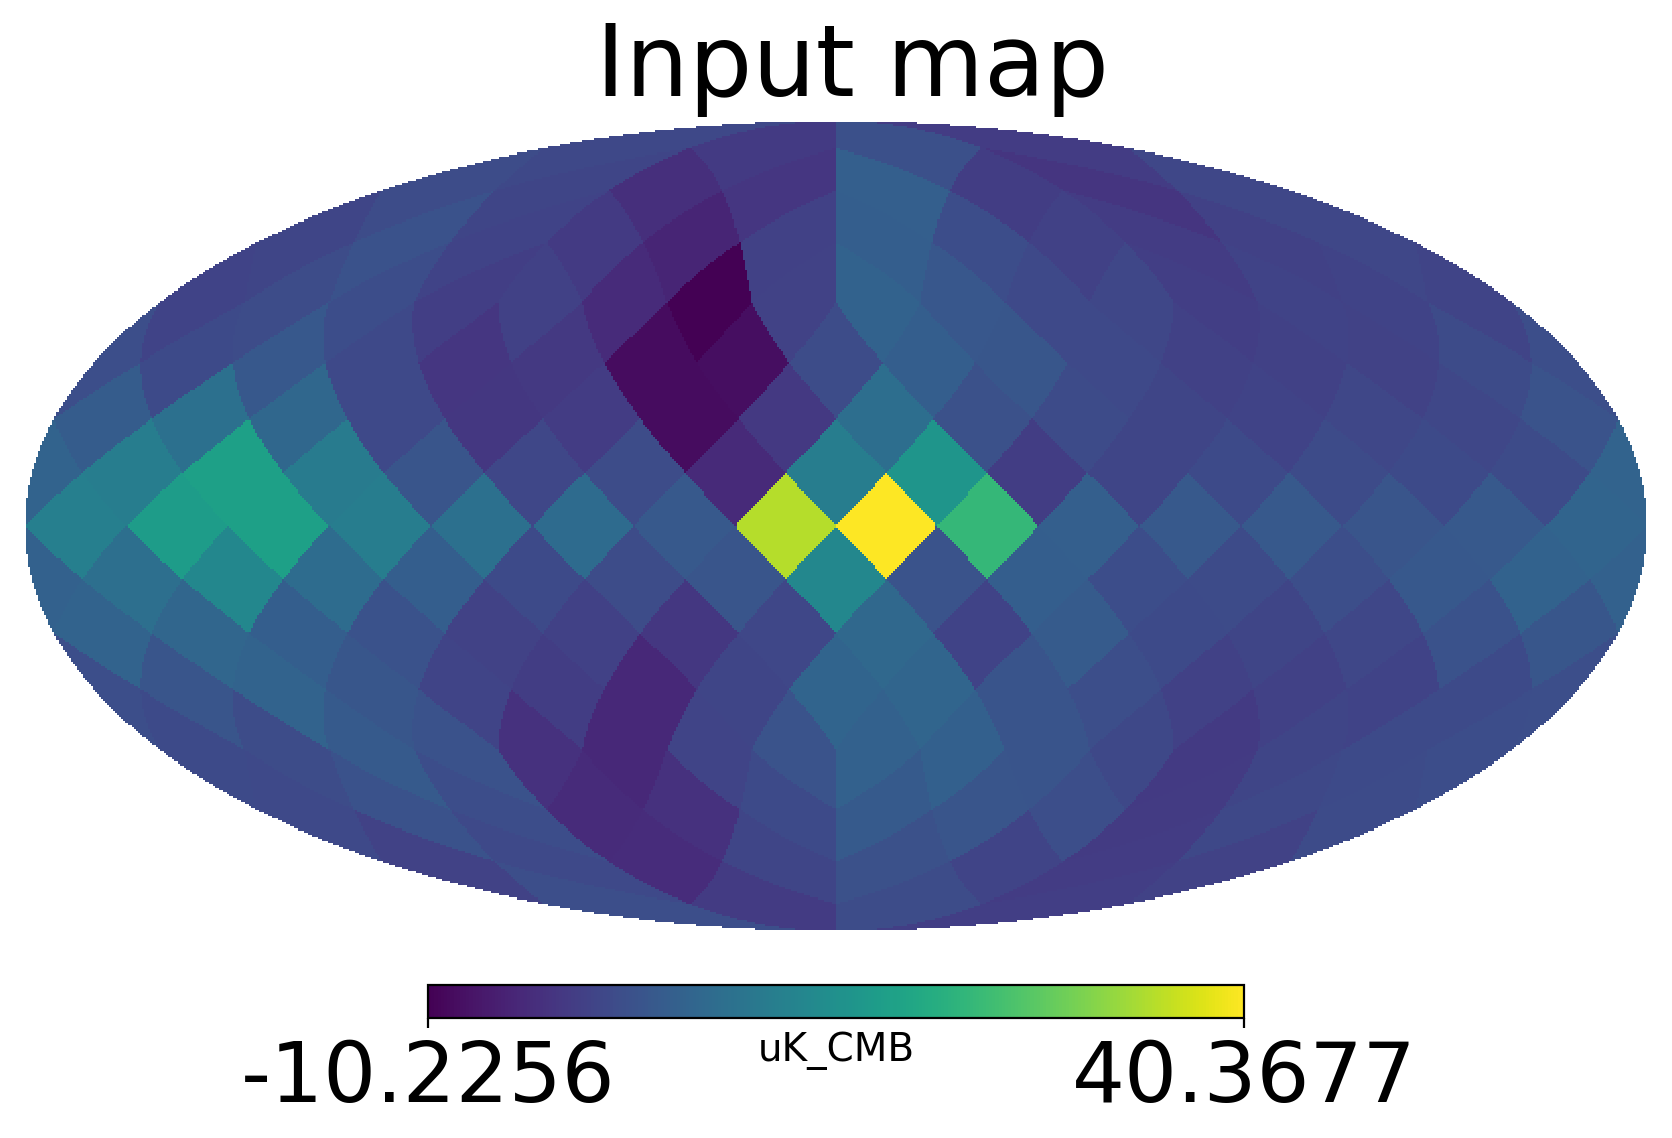

In [90]:
FG_map_Q = clean_map[N_pix*4:N_pix*5]
FG_map_U = clean_map[N_pix*5:N_pix*6]

hp.mollview(FG_map_Q, title=" FG map", unit = map_Synch_40GHz.unit)
hp.mollview(map_Synch_40GHz[1], title=" Input map", unit = map_Synch_40GHz.unit)